# Welcome to GENERALIST tutorial jupyter notebook! 
GENERALIST is a generative model for categorical data. We apply it to protein sequences (21 categories, 20 amino acids + gap), to obtain new sequences. 
We assess the quality of this model through various tests like reproducablity of the statistics of the data and the Hamming distances. 

In this notebook we will use fasta file for BPT1 present in this repo, you can swap that for any other fasta file. 

We will:
- Use BPT1 fasta file for this tutorial ==>`` '../data/msa_BPT1_unimsa.fa'``  and run the inference algorithm
- obtain generated sequences 
- run tests on those sequences 

When changing data from string (amino acid letters) to numerical form, we use the correspondance ``AA_Letters = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-' ]`` ==> [0,1,2,....,20]

In [1]:
# add relevant paths
import sys
import numpy as np
sys.path.append('../src')
sys.path.append('../data')

To run generalist we need to one hot encode the msa. The function ``Convert_fastaToNp`` takes in a fasta file and gets a 3-D binary matrix of shape ==> [Number of categories (21), Number of sequences, Number of positions in a sequence ]. 



If you are working with another type of categorical data you can one hot encode your data to be of the shape ==> [Number of categories , Number of samples , Number of features] and run GENERALIST on that. 

If your FASTA file does not include labels for the sequences (i.e. no >sequence label line, only the sequeneces) then set the argument ``labels_inc=False`` in ``Convert_fastaToNp`` function

In [2]:
from data_process_fns import Convert_fastaToNp
FastaFilePath  = '../data/msa_BPT1_unimsa.fa' # file path of the fasta file 
data_one_hot = Convert_fastaToNp(filepath = FastaFilePath, binary = True, labels_inc =True)


## Initialize the model

The class Generalist is initialized by determining the one hot encoding data, the model latent dimension ``k``. The model parameters $z$ and $\theta$ are initialized randomly.  
$K$ is the latent dimension for the model, and is specified by the user. 



In [3]:
## initializing an instance of the model generalist
from generalist_class import Generalist
k = 42
generalist = Generalist(data_one_hot,k )

## Run the inference 

In the training the model learns the probabilities of having any category/amino acid $a$ in any position $l$ in any specific sample $n$
$$\pi_{anl} = \frac{\exp(- \sum_k z_{nk} \theta_{akl})}{\Omega_{nl}}$$


``generalist`` uses GPU is available for computation, if not it will use CPU. If GPU is available but you want to run using CPU specify the argument ``use_gpu_if_avail = False`` for the method ``train``


In [4]:
generalist.train() #use_gpu_if_avail = True

running on cpu
one hot encoded data of size (21, 16569, 51)
started inference...
takes 0.49086809158325195 seconds for the first step
inference is over
step takes 0.5797219268720726 seconds 
inference done in 8.966365802288056 minutes for k = 42


## Generate data from the model

Now that the model is trained, we can use the learned probabilies to generate new sequences/samples. The ``generate`` method uses the learned probabilities $\pi$ to sample new sequences. 

The generated sequences are in Numerical form [0..20] by default,  or one-hot-encoded if the method argument ``output_binary = True``. 

In [5]:
ngen = 16569 #same number of sequences in natural MSA 
generated_data = generalist.generate(nGen = ngen) # output_binary = False

## Analysis
Now that we have some generated sequences, we can run various tests on them to see how well they match the original ones. 

### The statistics
Calculating single site frequencies the mean removed correlation of various orders. 
The funciton ``Calc_nBody_Corr`` takes the original dataset and the generated dataset as arguments, as well as the order of the statistics, and obtains arrays for the frequencies of amino acid combinations in both datasets. 

For order > 1, 7000 amino acid combinaitons are randomly sampled, to change that number use the argument ``nTest`` in ``Calc_nBody_Corr``. 

Also for order > 1, the frequencies are mean removed , to change that use the argument ``mean_removed=False`` 

In [6]:
from performance_fns import Calc_nBody_Corr, calculate_r_metric
import matplotlib.pyplot as plt

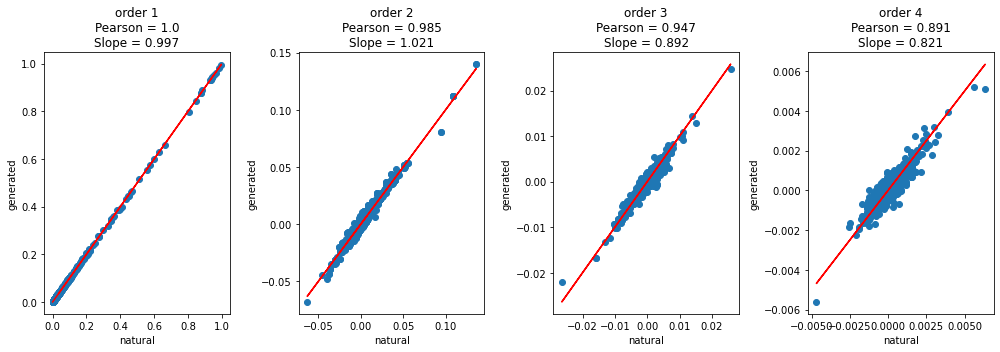

In [7]:
# correlation
order_list = [1,2,3,4]
fig, ax = plt.subplots(ncols = len(order_list), figsize = (14,5))
i = 0
for order in order_list: 
    freq_og, freq_gen =  Calc_nBody_Corr(data_one_hot, generated_data, n = order, mean_removed = True) #nTest = 7000 ,mean_removed = True
    r = np.corrcoef(freq_og, freq_gen)[0,1] #pearson corr coeff
    a, b = np.polyfit(freq_og, freq_gen, deg=1) #slope of linear fit line
    ax[i].scatter(freq_og, freq_gen)
    ax[i].plot(freq_og, freq_og, c = 'r')
    ax[i].set_title(f'order {order}\nPearson = {np.round(r,3)}\nSlope = {np.round(a,3)}')
    ax[i].set_xlabel(f'natural')
    ax[i].set_ylabel(f'generated')
    i+=1 
plt.tight_layout()

### $r_m$

We use the metric published in [McGee, F. et al. The generative capacity of probabilistic protein sequence models. Nat Commun 12, 6302 (2021)](https://www.nature.com/articles/s41467-021-26529-9) to assess the ability of GENERALIST to capture even higher order statistics. In the paper $m = 20$, in our implementation of the function, ``m`` is an argument. 
This function calculated the average of the pearson coefficient of correlation obtained from multiple repitions (default 100), for each statisitcs order $n$. 

The argument ``nlist`` is the list of orders you want to plot, it is ``nlist = np.arange(1,11)`` by default
 

In [8]:
nlist = np.arange(1,11)

r_arr = calculate_r_metric(data_one_hot, generated_data, nlist = nlist, verbose = 1)


0.687086820602417 seconds to finish n =  1
2.1731090545654297 seconds to finish n =  2
7.891424179077148 seconds to finish n =  3
19.98032784461975 seconds to finish n =  4
43.766844272613525 seconds to finish n =  5
70.22574710845947 seconds to finish n =  6
94.92919516563416 seconds to finish n =  7
122.75313401222229 seconds to finish n =  8
148.5782768726349 seconds to finish n =  9
171.24452567100525 seconds to finish n =  10


(0.0, 1.1)

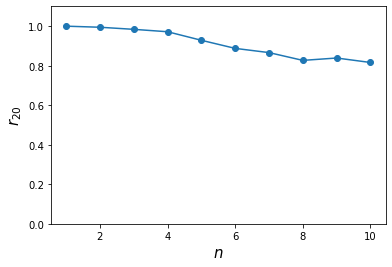

In [9]:
nlist = np.arange(1,11)
i = 0
plt.plot(nlist,r_arr)
plt.scatter(nlist, r_arr)
plt.ylabel(r'$r_{20}$', fontsize = 15)
plt.xlabel(f'$n$', fontsize = 15)
plt.ylim([0,1.1])


### Hamming distance
We can look at the density of the inferred sequence space through calculating the normalized Hamming distance between 
- the generated sequences and their closest natural neighbors -- $h_{min}$ to MSA -- function ``calc_ham_arr``
- the generated sequences and their closest generated neighbor, same with the natural sequences. -- $h_{min}$ within the ensemble -- funtion ``calc_ham_arr``
- random pairs of sequences in the same ensemble -- $h_{rand}$ within the ensemble -- funtion ``cal_ham_randompairs``

In [10]:
from performance_fns import calc_ham_arr , cal_ham_randompairs


In [11]:
min_ham_tomsa = calc_ham_arr(data_one_hot, generated_data) #min hamming distance between generated sequence and MSA
min_ham_nat = calc_ham_arr(data_one_hot, data_one_hot , same_data = True) # minimum hamming distance between natural sequences and natural neighbors
min_ham_gen = calc_ham_arr(generated_data, generated_data , same_data = True)# minimum hamming distance between generated sequences and generated neighbors
rand_ham_gen = cal_ham_randompairs(generated_data, generated_data) # hamming distance between random pairs in generated sequences - default number of pairs = 1000
rand_ham_nat = cal_ham_randompairs(data_one_hot, data_one_hot) # hamming distance between random pairs in natural sequences - default number of pairs = 1000

two datasets are the same, removing the examined sequence from comparison
two datasets are the same, removing the examined sequence from comparison


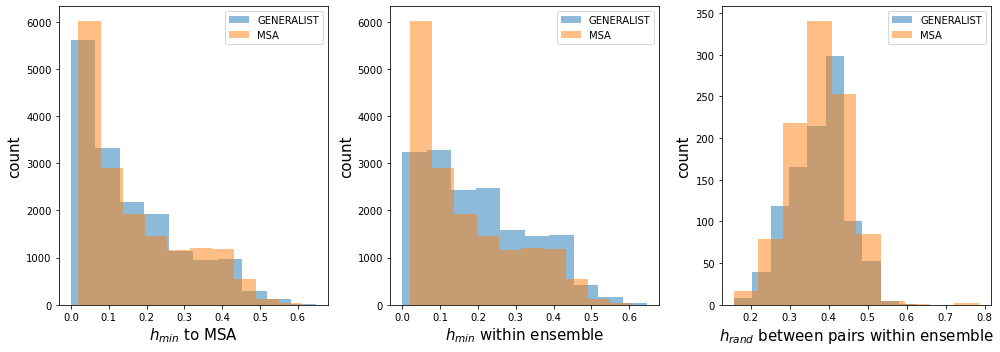

In [12]:
fig, ax = plt.subplots(ncols = 3, figsize = (14,5))
i = 0
ax[i].hist(min_ham_tomsa, label = 'GENERALIST', alpha = .5)
ax[i].hist(min_ham_nat, label = 'MSA', alpha = .5)
ax[i].set_xlabel(r'$h_{min}$ to MSA', fontsize = 15)
ax[i].set_ylabel('count', fontsize = 15)
ax[i].legend()
i+=1 
ax[i].hist(min_ham_gen, label = 'GENERALIST', alpha = .5)
ax[i].hist(min_ham_nat, label = 'MSA', alpha = .5)
ax[i].set_xlabel(r'$h_{min}$ within ensemble', fontsize = 15)
ax[i].set_ylabel('count', fontsize = 15)
ax[i].legend()

i+=1 
ax[i].hist(rand_ham_gen, label = 'GENERALIST', alpha = .5)
ax[i].hist(rand_ham_nat, label = 'MSA', alpha = .5)
ax[i].set_xlabel(r'$h_{rand}$ between pairs within ensemble', fontsize = 15)
ax[i].set_ylabel('count', fontsize = 15)
ax[i].legend()


plt.tight_layout()